# Подключение библиотек

In [1]:
import numpy as np

import torch
from torch import nn
import statsmodels.api as sm

import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

%matplotlib inline
import matplotlib.pyplot as plt

import torchsde

# Генерация сэмпла

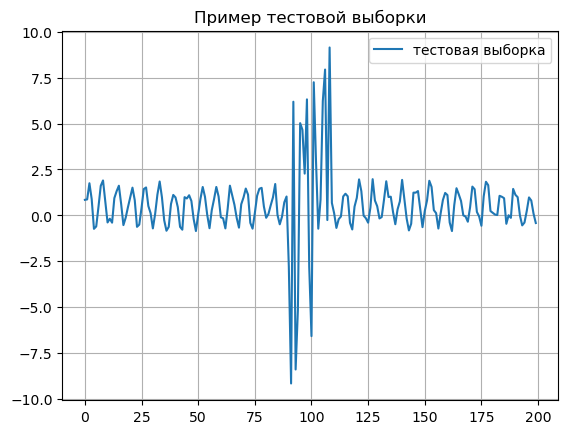

In [2]:
N = 200
samples = np.arange(N)

sinuses = np.sin(samples) # синусы


norm_noise = sinuses + np.random.normal(loc=0, scale=5, size=N)
uni_noise = sinuses + np.random.uniform(low=0, high=1, size=N)
X = uni_noise[:90]
Z = norm_noise[90:110]
Y = uni_noise[110:]

vals = X
vals = np.append(vals, Z)
vals = np.append(vals, Y)

vals_size = len(vals)

plt.title('Пример тестовой выборки')
plt.plot(np.arange(vals_size), vals, label='тестовая выборка')
plt.legend()
plt.grid()

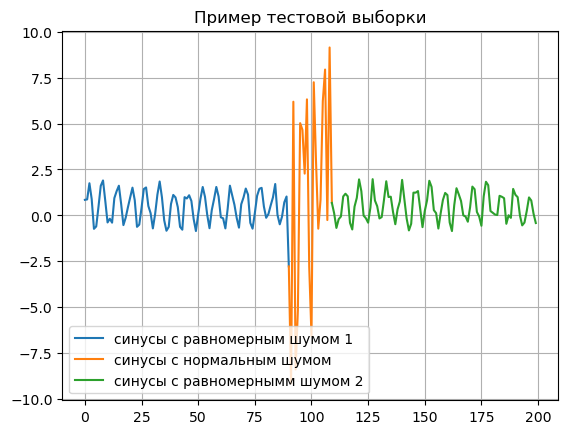

In [3]:
plt.title('Пример тестовой выборки')
plt.plot(np.arange(len(X) + 1), vals[:len(X)+1], label='синусы с равномерным шумом 1')
plt.plot(np.arange(len(Z)) + len(X), Z, label='синусы с нормальным шумом')
plt.plot(np.arange(len(Y) + 1) + len(X) + len(Z) - 1, vals[len(X) + len(Z) - 1:], label='синусы с равномернымм шумом 2')
plt.legend()
plt.grid()

# Настройка класса модели Neural SDE

In [4]:
batch_size = 25 # 25 прогнозов одномерного временного ряда из N элементов

class SDE(torch.nn.Module):
    noise_type = 'general'
    sde_type = 'stratonovich'

    def __init__(self, input_size, output_size, brownian_size = 2):
        super().__init__()
        self.mu = torch.nn.Linear(input_size, 
                                  output_size, dtype=float)
        self.sigma = torch.nn.Linear(input_size, 
                                     output_size * brownian_size, dtype=float)
        self.gamma = nn.Parameter(torch.tensor(0.1), requires_grad=True)

        self.input_size = input_size
        self.output_size = output_size
        self.brownian_size = brownian_size
        
    # Drift
    def f(self, t, y):
        return torch.cos(t * (self.output_size-1)) * self.mu(y)  

    # Diffusion
    def g(self, t, y):
        return torch.exp(-self.gamma * t * (self.output_size-1)) * self.sigma(y).view(batch_size, 
                                  self.output_size, 
                                  self.brownian_size)

if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

# Определение вспомогательных функций для проведения эксперимента

In [13]:
print(vals)

[ 8.37912104e-01  8.61471005e-01  1.74252622e+00  8.78873439e-01
 -7.42894055e-01 -6.12664655e-01  4.60568402e-01  1.60219288e+00
  1.89502692e+00  7.76918968e-01 -3.95273277e-01 -1.91688900e-01
 -4.07219011e-01  9.33185346e-01  1.30748611e+00  1.60769167e+00
  6.16735996e-01 -5.40053271e-01 -1.36625845e-01  4.36249707e-01
  9.75355234e-01  1.50332753e+00  8.21641923e-01 -6.34299430e-01
 -5.13974016e-01  4.03715478e-01  1.42809574e+00  1.51285782e+00
  5.02697278e-01  1.11495585e-01 -7.19082489e-01  6.86497867e-02
  1.12186568e+00  1.83740692e+00  9.81187014e-01 -2.76189523e-01
 -8.47015656e-01 -6.37681801e-01  6.11915176e-01  1.10515795e+00
  9.69333351e-01  4.41532184e-01 -6.35687961e-01 -7.89687685e-01
  9.83572416e-01  9.12287289e-01  1.08808891e+00  7.77057053e-01
 -2.08745918e-01 -8.62403735e-01  4.78461768e-02  8.94209729e-01
  1.53962901e+00  1.00186788e+00  7.31648839e-03 -7.08762746e-01
  2.78590753e-01  8.75682009e-01  1.54062370e+00  1.02400572e+00
 -1.14324379e-01 -1.68571

In [21]:
window_size = 25
y0 = torch.from_numpy(np.tile(vals[:window_size], batch_size)).view(batch_size, window_size).to(device)
print(y0)

tensor([[ 0.8379,  0.8615,  1.7425,  0.8789, -0.7429, -0.6127,  0.4606,  1.6022,
          1.8950,  0.7769, -0.3953, -0.1917, -0.4072,  0.9332,  1.3075,  1.6077,
          0.6167, -0.5401, -0.1366,  0.4362,  0.9754,  1.5033,  0.8216, -0.6343,
         -0.5140],
        [ 0.8379,  0.8615,  1.7425,  0.8789, -0.7429, -0.6127,  0.4606,  1.6022,
          1.8950,  0.7769, -0.3953, -0.1917, -0.4072,  0.9332,  1.3075,  1.6077,
          0.6167, -0.5401, -0.1366,  0.4362,  0.9754,  1.5033,  0.8216, -0.6343,
         -0.5140],
        [ 0.8379,  0.8615,  1.7425,  0.8789, -0.7429, -0.6127,  0.4606,  1.6022,
          1.8950,  0.7769, -0.3953, -0.1917, -0.4072,  0.9332,  1.3075,  1.6077,
          0.6167, -0.5401, -0.1366,  0.4362,  0.9754,  1.5033,  0.8216, -0.6343,
         -0.5140],
        [ 0.8379,  0.8615,  1.7425,  0.8789, -0.7429, -0.6127,  0.4606,  1.6022,
          1.8950,  0.7769, -0.3953, -0.1917, -0.4072,  0.9332,  1.3075,  1.6077,
          0.6167, -0.5401, -0.1366,  0.4362,  0.9754

In [22]:
hank = y0.clone()
target = torch.full((window_size, batch_size, window_size), 0.0)

for i in range(window_size):
    hank[i] = torch.from_numpy(np.array(vals[i:i+window_size]))

for i in range(batch_size):
    target[:][i][:] = hank

In [23]:
print(target)

tensor([[[ 0.8379,  0.8615,  1.7425,  ...,  0.8216, -0.6343, -0.5140],
         [ 0.8615,  1.7425,  0.8789,  ..., -0.6343, -0.5140,  0.4037],
         [ 1.7425,  0.8789, -0.7429,  ..., -0.5140,  0.4037,  1.4281],
         ...,
         [ 0.8216, -0.6343, -0.5140,  ...,  0.9836,  0.9123,  1.0881],
         [-0.6343, -0.5140,  0.4037,  ...,  0.9123,  1.0881,  0.7771],
         [-0.5140,  0.4037,  1.4281,  ...,  1.0881,  0.7771, -0.2087]],

        [[ 0.8379,  0.8615,  1.7425,  ...,  0.8216, -0.6343, -0.5140],
         [ 0.8615,  1.7425,  0.8789,  ..., -0.6343, -0.5140,  0.4037],
         [ 1.7425,  0.8789, -0.7429,  ..., -0.5140,  0.4037,  1.4281],
         ...,
         [ 0.8216, -0.6343, -0.5140,  ...,  0.9836,  0.9123,  1.0881],
         [-0.6343, -0.5140,  0.4037,  ...,  0.9123,  1.0881,  0.7771],
         [-0.5140,  0.4037,  1.4281,  ...,  1.0881,  0.7771, -0.2087]],

        [[ 0.8379,  0.8615,  1.7425,  ...,  0.8216, -0.6343, -0.5140],
         [ 0.8615,  1.7425,  0.8789,  ..., -0

In [24]:
target.shape

torch.Size([25, 25, 25])

In [25]:
ts = torch.linspace(0, 1, window_size).to(device)
predict = torchsde.sdeint_adjoint(my_sde, y0, ts)
print(predict.shape)

RuntimeError: mat1 and mat2 shapes cannot be multiplied (25x25 and 20x20)

In [26]:
from torch.utils.data import TensorDataset, DataLoader

def train_SDE(window_size, values, iters_cnt_for_study = 100):
    t_size = window_size

    sde = SDE(window_size, window_size).to(device)


    ts = torch.linspace(0, 1, t_size).to(device) # разметка временного диапазона
    y0 = torch.from_numpy(np.tile(values[:window_size], batch_size)).view(batch_size, window_size).to(device) # начальная точка временного ряда
    optimizer = torch.optim.SGD(sde.parameters(), lr=0.01)

    hank = y0.clone()
    target = torch.full((window_size, batch_size, window_size), 0.0)

    for i in range(window_size):
        hank[i] = torch.from_numpy(np.array(vals[i:i+window_size]))
        
    for i in range(batch_size):
        target[:][i][:] = hank

    losses = np.array([], dtype=float)
    for i in range(iters_cnt_for_study):
        predict = torchsde.sdeint_adjoint(sde, y0, ts)  
        loss = ((target - predict) ** 2).mean()

        losses = np.append(losses, loss.cpu().detach().numpy())
        
        loss.backward()
        optimizer.step()  # обновляем параметры сети
        optimizer.zero_grad()  # обнуляем посчитанные градиенты параметров
        
    return sde, losses


def predict_SDE(model, values):
    window_size = model.output_size
    t_size = window_size
    
    hankel_matrix = []
    cur_row = values[:window_size]
    hankel_matrix.append(cur_row)
    
    for step in range(0, len(values) - t_size):
        ts = torch.linspace(step / (t_size - 1), 1 + step / (t_size - 1), t_size).to(device) # разметка временного диапазона
        y0 = torch.from_numpy(np.tile(cur_row, batch_size)).view(batch_size, window_size).to(device) # начальная точка временного ряда
        #y0 = torch.from_numpy(np.tile(values[step:window_size + step], batch_size)).view(batch_size, window_size).to(device)

        
        predict = torchsde.sdeint_adjoint(model, y0, ts)  

        ys = predict
        ts = ts.cpu()

        
        avg = np.mean(np.mean(np.array([sample.detach().cpu().numpy() for i, sample in enumerate(ys)], dtype=float), axis=0), axis=0)
        cur_row = np.roll(cur_row, -1)
        cur_row[-1] = avg[-1]

        hankel_matrix.append(cur_row)


    return np.array(hankel_matrix) 

def get_params_from_hankel(hankel_matrix):
    len_vals = len(hankel_matrix[0])
    window_size = len(hankel_matrix)

    sums = np.full(len_vals + window_size - 1, 0, dtype=float)
    sums_sq = np.full(len_vals + window_size - 1, 0, dtype=float)
    cnts = np.full(len_vals + window_size - 1, 0, dtype=float)
    
    for i in range(len_vals):
        for j in range(window_size):
            sums[i + j] += hankel_matrix[j][i]
            sums_sq[i + j] += hankel_matrix[j][i] ** 2
            cnts[i + j] += 1

    original = hankel_matrix[0]
    prediction = hankel_matrix[-1]

    means = sums / cnts
    dysps = sums_sq / cnts - means ** 2
    #print(cnts)
    
    return original, prediction, means, dysps

# Обучение модели на временном ряду

In [34]:
my_sde, losses = train_SDE(25, vals, 900)

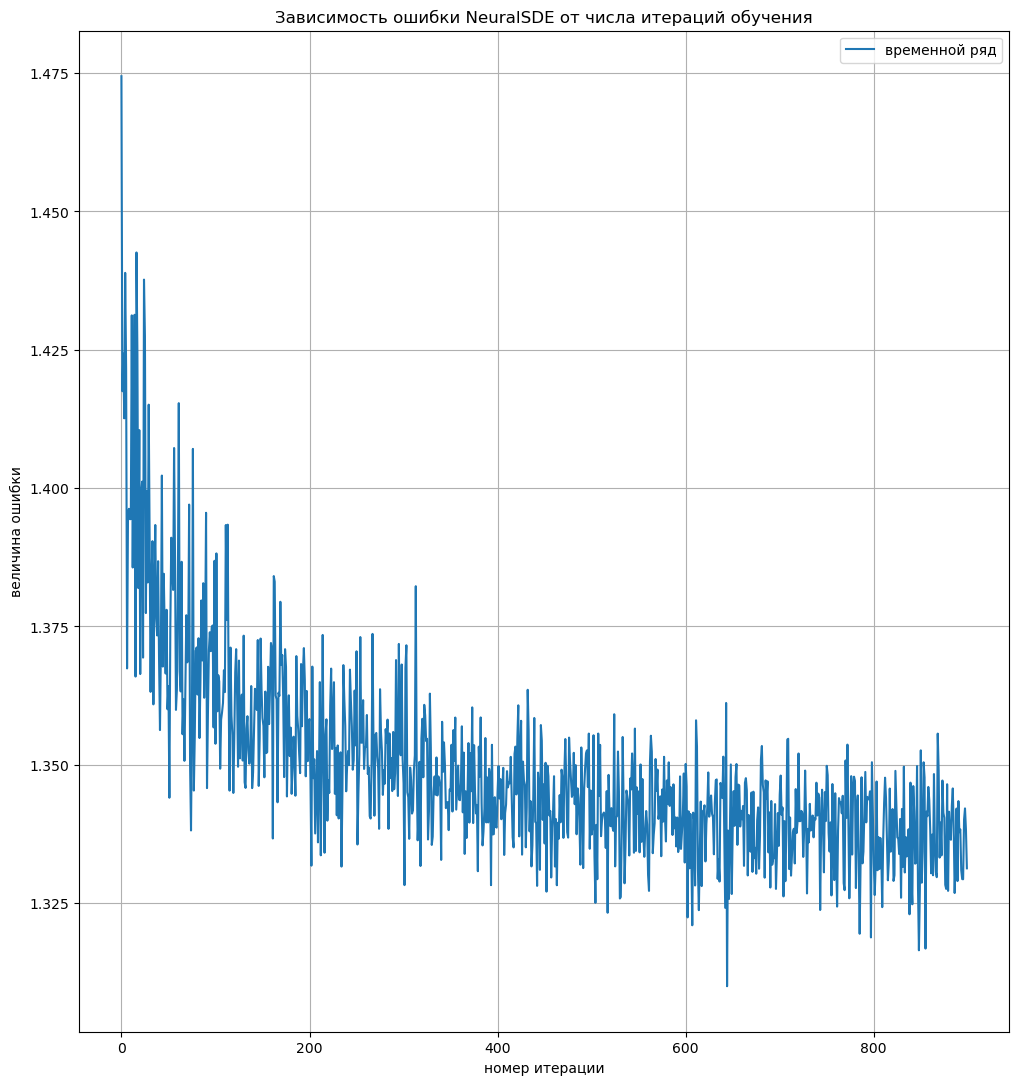

In [35]:
plt.figure(figsize = (12, 13))

plt.plot(np.arange(len(losses)), losses, label='временной ряд')

plt.title('Зависимость ошибки NeuralSDE от числа итераций обучения')
plt.xlabel('номер итерации')
plt.ylabel('величина ошибки')
plt.legend()
plt.grid()

In [36]:
step=1
ts = torch.linspace(step / (my_sde.output_size - 1), 1 + step / (my_sde.output_size - 1), my_sde.output_size).to(device) # разметка временного диапазона
#ts = torch.linspace(0, 1, my_sde.output_size).to(device)
#y0 = torch.from_numpy(np.tile(vals[:my_sde.output_size], batch_size)).view(batch_size, my_sde.output_size).to(device) # начальная точка временного ряда

y0 = torch.from_numpy(np.tile(vals[step - 1:step - 1 + my_sde.output_size], batch_size)).view(batch_size, my_sde.output_size).to(device)
predict = torchsde.sdeint_adjoint(my_sde, y0, ts)  

ys = predict
ts = ts.cpu()

        
avg = np.mean(np.mean(np.array([sample.detach().cpu().numpy() for i, sample in enumerate(ys)], dtype=float), axis=0), axis=0)

In [37]:
print(y0)

tensor([[ 0.8379,  0.8615,  1.7425,  0.8789, -0.7429, -0.6127,  0.4606,  1.6022,
          1.8950,  0.7769, -0.3953, -0.1917, -0.4072,  0.9332,  1.3075,  1.6077,
          0.6167, -0.5401, -0.1366,  0.4362,  0.9754,  1.5033,  0.8216, -0.6343,
         -0.5140],
        [ 0.8379,  0.8615,  1.7425,  0.8789, -0.7429, -0.6127,  0.4606,  1.6022,
          1.8950,  0.7769, -0.3953, -0.1917, -0.4072,  0.9332,  1.3075,  1.6077,
          0.6167, -0.5401, -0.1366,  0.4362,  0.9754,  1.5033,  0.8216, -0.6343,
         -0.5140],
        [ 0.8379,  0.8615,  1.7425,  0.8789, -0.7429, -0.6127,  0.4606,  1.6022,
          1.8950,  0.7769, -0.3953, -0.1917, -0.4072,  0.9332,  1.3075,  1.6077,
          0.6167, -0.5401, -0.1366,  0.4362,  0.9754,  1.5033,  0.8216, -0.6343,
         -0.5140],
        [ 0.8379,  0.8615,  1.7425,  0.8789, -0.7429, -0.6127,  0.4606,  1.6022,
          1.8950,  0.7769, -0.3953, -0.1917, -0.4072,  0.9332,  1.3075,  1.6077,
          0.6167, -0.5401, -0.1366,  0.4362,  0.9754

In [38]:
print(predict[:][1][:])

tensor([[ 0.8468,  0.8366,  1.7683,  0.9176, -0.7619, -0.5871,  0.4496,  1.5488,
          1.8906,  0.7827, -0.3883, -0.2222, -0.3708,  0.9429,  1.3250,  1.6191,
          0.6355, -0.5188, -0.1552,  0.4255,  0.9766,  1.5088,  0.8406, -0.6300,
         -0.5010],
        [ 0.9402,  0.8736,  1.7626,  0.9677, -0.7224, -0.5478,  0.4851,  1.6067,
          1.9092,  0.7780, -0.3293, -0.1375, -0.3310,  0.8805,  1.2835,  1.5447,
          0.6632, -0.5198, -0.1144,  0.4968,  0.9815,  1.4666,  0.9281, -0.6882,
         -0.4087],
        [ 0.8726,  0.8877,  1.7340,  0.8915, -0.7189, -0.6068,  0.4813,  1.6432,
          1.9005,  0.7766, -0.3744, -0.1474, -0.3999,  0.9038,  1.2860,  1.5726,
          0.6236, -0.5423, -0.1110,  0.4693,  0.9792,  1.4833,  0.8573, -0.6611,
         -0.4745],
        [ 0.9209,  0.9237,  1.7225,  0.9132, -0.6868, -0.5834,  0.4966,  1.6847,
          1.9066,  0.7748, -0.3490, -0.0875, -0.3853,  0.8694,  1.2633,  1.5237,
          0.6294, -0.5447, -0.0886,  0.5055,  0.9877

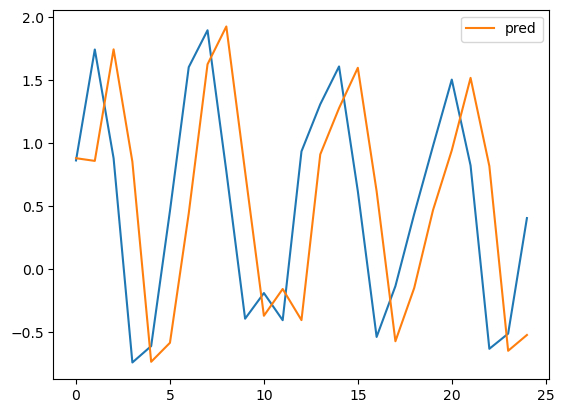

In [40]:
plt.plot(np.arange(25), vals[step:25+step])
plt.plot(np.arange(25), avg, label='pred')
plt.legend()

In [105]:
print(predict.shape)

torch.Size([20, 25, 20])


In [98]:
ts_1 = torch.linspace(step / (my_sde.output_size - 1), 1 + step / (my_sde.output_size - 1), my_sde.output_size).to(device) # разметка временного диапазона
ts_2 = torch.linspace(0, 1, my_sde.output_size).to(device)

In [99]:
print(ts_1)
print(ts_2)

tensor([0.4737, 0.5263, 0.5789, 0.6316, 0.6842, 0.7368, 0.7895, 0.8421, 0.8947,
        0.9474, 1.0000, 1.0526, 1.1053, 1.1579, 1.2105, 1.2632, 1.3158, 1.3684,
        1.4211, 1.4737])
tensor([0.0000, 0.0526, 0.1053, 0.1579, 0.2105, 0.2632, 0.3158, 0.3684, 0.4211,
        0.4737, 0.5263, 0.5789, 0.6316, 0.6842, 0.7368, 0.7895, 0.8421, 0.8947,
        0.9474, 1.0000])


In [100]:
print(avg)

[ 1.16856163  1.36178285 -0.24191488 -0.79291454 -0.3554223   0.80490234
  1.9006584   1.39086855  0.16754047 -0.34159761 -0.68738082  0.65265791
  0.97222911  1.39312182  0.68564216 -0.84803337 -0.02780797  0.80626808
  1.24909471  1.097703  ]


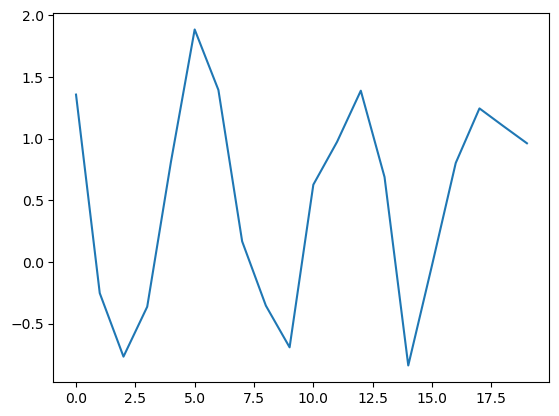

In [95]:
plt.plot(np.arange(20), vals[step:20+step])

# Построение/визуализация прогнозов. Нахождение точек разладки

In [14]:
def search_breakdown_points(values, dysps, means):
    points_x = np.array([], dtype=float)
    points_y = np.array([], dtype=float)
    cnt_points = 0
    
    for i in range(len(values)):
        if (values[i] < means[i] - dysps[i] or values[i] > means[i] + dysps[i]):
            points_x = np.append(points_x, i)
            points_y = np.append(points_y, values[i])
            cnt_points += 1
            
    return cnt_points, points_x, points_y

In [36]:
#window_sizes = np.arange(5, 80, 15)
window_sizes = [0]

counts = np.array([], dtype=float)
p_x = []
p_y = []

for w in window_sizes:
    cnt, px_t, py_t = search_breakdown_points(my_sde, vals)
    
    counts = np.append(counts, cnt)
    p_x.append(px_t)
    p_y.append(py_t)

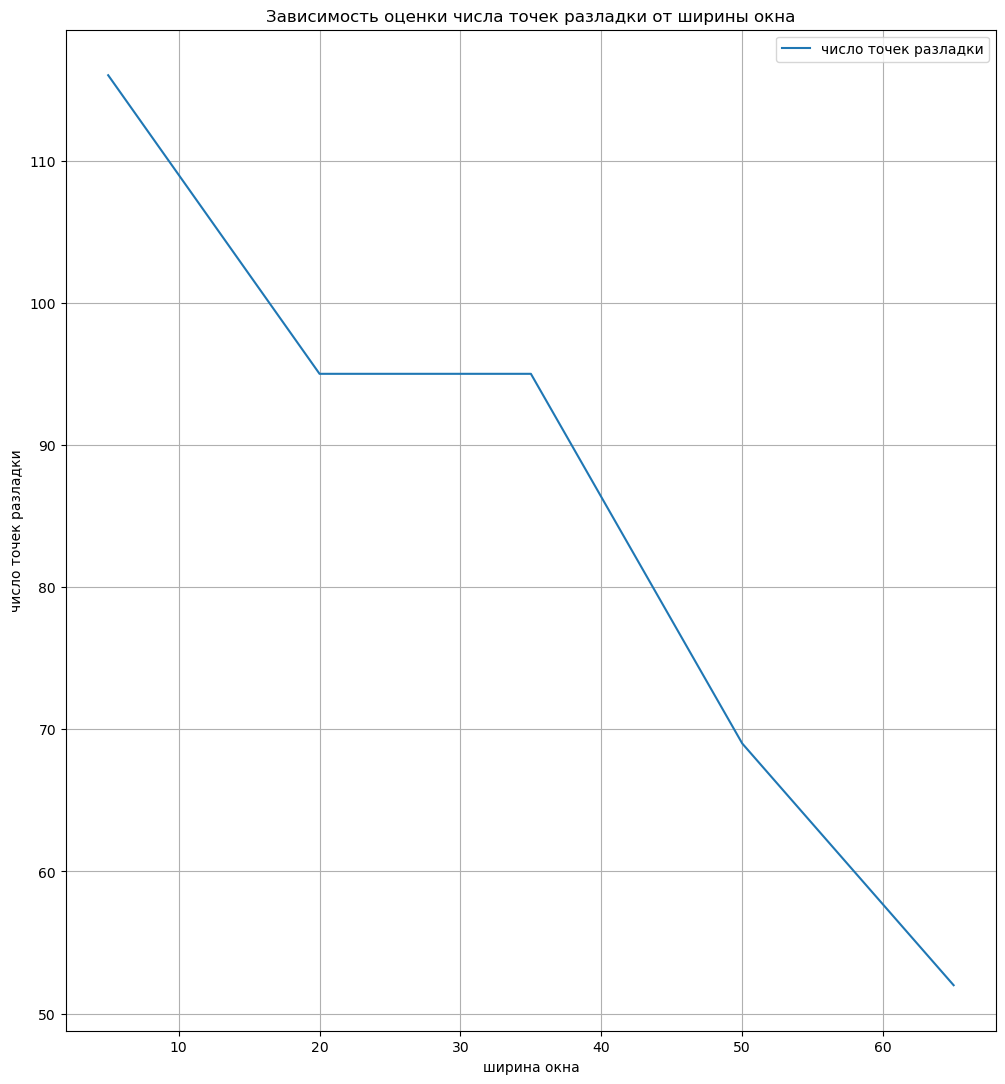

In [43]:
plt.figure(figsize = (12, 13))

plt.plot(window_sizes, counts, label='число точек разладки')


plt.title('Зависимость оценки числа точек разладки от ширины окна')
plt.xlabel('ширина окна')
plt.ylabel('число точек разладки')
plt.legend()
plt.grid()

In [44]:
final_window_size = window_sizes[np.argmin(counts)]
print('Итого для проведения эксперимента выбрана ширина окна',str(final_window_size),'как самая стабильная.')

Итого для проведения эксперимента выбрана ширина окна 65 как самая стабильная.


In [ ]:
#new_sde = SDE(20, 20).to(device)
Hankel_Mat = predict_SDE(my_sde, vals)
orig, cont, means, dysps = get_params_from_hankel(Hankel_Mat)

plt.figure(figsize = (12, 13))

plt.plot(np.arange(len(vals)), vals, label='временной ряд')
plt.plot(np.arange(len(cont)) + len(vals) - 1, cont, label='его продолжение')
plt.fill_between(np.arange(len(vals)), means - dysps, means + dysps, color='green',alpha=0.1, label='довер.инт.')

#cnt, px_t, py_t = search_breakdown_points(vals, dysps, means)
plt.scatter(px_t, py_t, label='кандидаты в точки разладки')

plt.title('Конечный анализ временного ряда')
plt.xlabel('номер элемента')
plt.ylabel('значение')
plt.legend()
plt.grid()

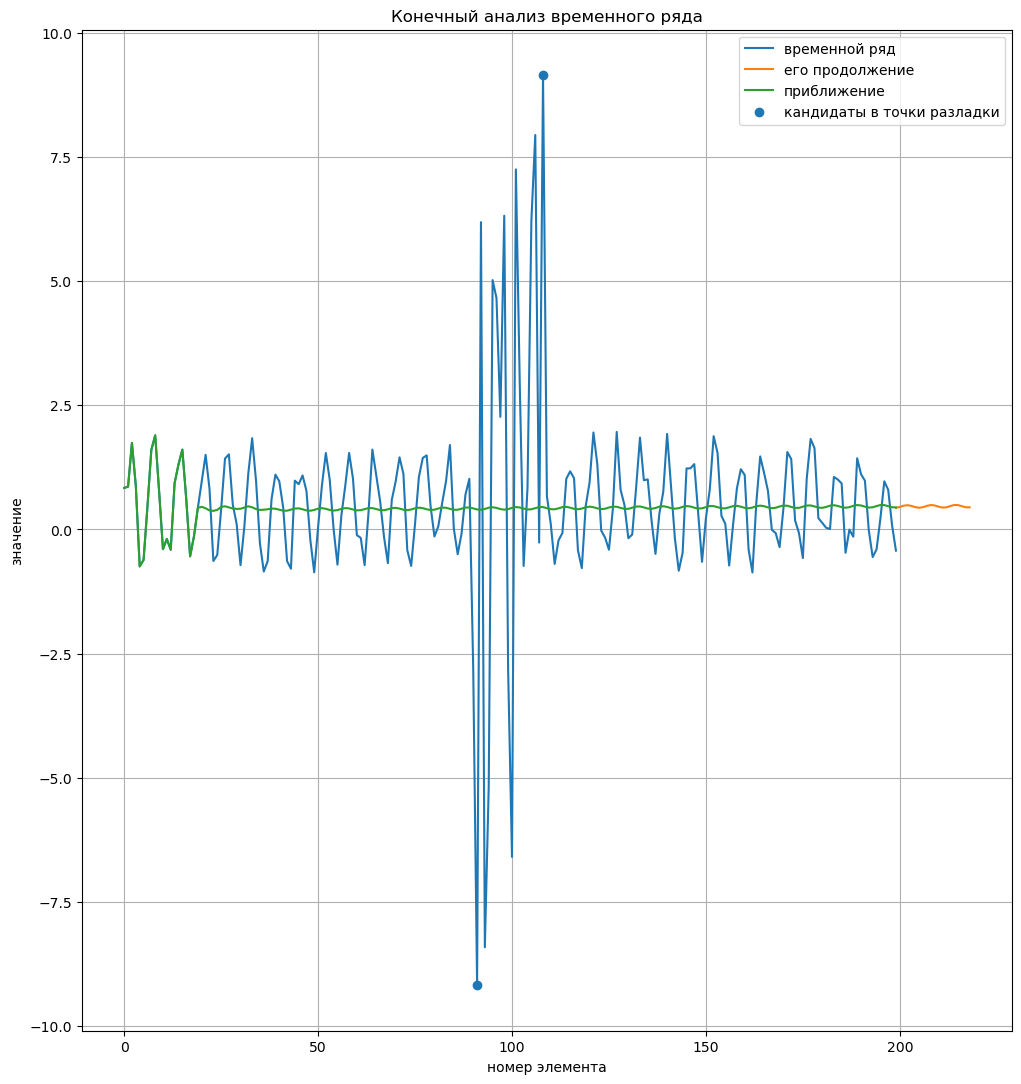

In [9]:
plt.figure(figsize = (12, 13))

plt.plot(np.arange(len(vals)), vals, label='временной ряд')
plt.plot(np.arange(len(cont)) + len(vals) - 1, cont, label='его продолжение')
#plt.fill_between(np.arange(len(vals)), means - dysps, means + dysps, color='green',alpha=0.9, label='довер.инт.')
plt.plot(np.arange(len(means)), means, label='приближение')

#cnt, px_t, py_t = search_breakdown_points(vals, dysps, means)
#plt.scatter(px_t, py_t, label='кандидаты в точки разладки')
plt.scatter([np.argmin(vals - means), np.argmax(vals - means)], [vals[np.argmin(vals - means)], vals[np.argmax(vals - means)]], label='кандидаты в точки разладки')

plt.title('Конечный анализ временного ряда')
plt.xlabel('номер элемента')
plt.ylabel('значение')
plt.legend()
plt.grid()

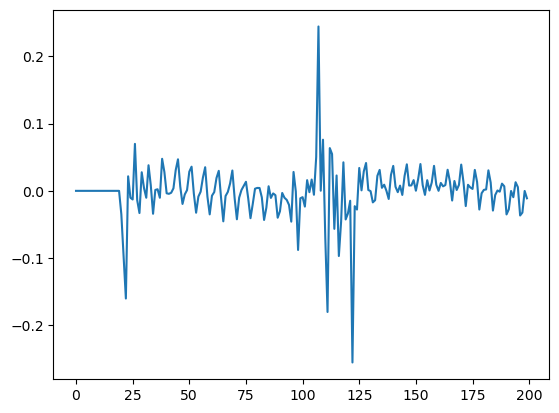

In [66]:
plt.plot(np.arange(len(vals)), vals - means)

In [60]:
print(dysps)

[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  5.55111512e-17 -2.77555756e-17  0.00000000e+00
 -2.22044605e-16  4.44089210e-16 -1.38777878e-17 -3.33066907e-16
  0.00000000e+00  0.00000000e+00 -8.88178420e-16  1.11022302e-15
  3.12250226e-17  1.38777878e-17  0.00000000e+00 -1.66533454e-16
 -8.88178420e-16  8.88178420e-16 -6.66133815e-16 -7.77156117e-16
  1.35525272e-20  0.00000000e+00 -8.88178420e-16  2.22044605e-16
  5.55111512e-16  2.77555756e-17  0.00000000e+00  0.00000000e+00
 -8.88178420e-16  1.77635684e-15 -4.44089210e-16  1.08420217e-19
  0.00000000e+00  0.00000000e+00  1.66533454e-16  6.66133815e-16
 -1.77635684e-15  2.08166817e-17 -3.46944695e-18 -3.25260652e-19
 -1.11022302e-16 -1.33226763e-15  8.88178420e-16  0.00000000e+00
 -1.38777878e-17 -6.93889390e-18  3.46944695e-18  2.22044605e-16
  8.88178420e-16 -4.44089210e-16 -2.77555756e-17  2.60208521e-18
 -4.16333634e-17 -1.11022302e-16 -1.33226763e-15  4.44089210e-16
 -5.55111512e-17  2.77555

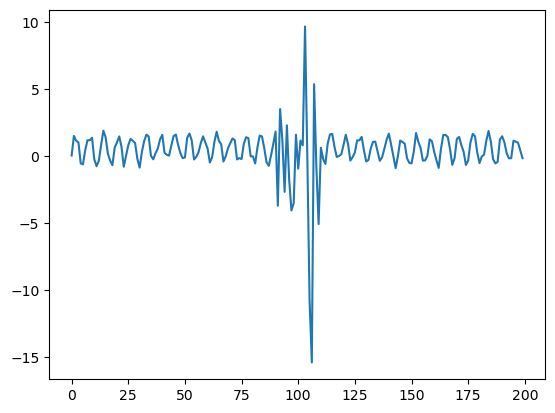

In [53]:
plt.plot(np.arange(len(vals)), means)

In [23]:
print(Hankel_Mat)

[[ 0.03396781  1.49993381  1.13707649  1.01854068 -0.55451974 -0.62521192
   0.43760406  1.17932562  1.16822394  1.35844977 -0.25122636 -0.76612233
  -0.36151731  0.81320963  1.88630337  1.39578935  0.16868822 -0.35283307
  -0.69065339  0.62807162]
 [ 1.49993381  1.13707649  1.01854068 -0.55451974 -0.62521192  0.43760406
   1.17932562  1.16822394  1.35844977 -0.25122636 -0.76612233 -0.36151731
   0.81320963  1.88630337  1.39578935  0.16868822 -0.35283307 -0.69065339
   0.62807162  0.6288906 ]
 [ 1.13707649  1.01854068 -0.55451974 -0.62521192  0.43760406  1.17932562
   1.16822394  1.35844977 -0.25122636 -0.76612233 -0.36151731  0.81320963
   1.88630337  1.39578935  0.16868822 -0.35283307 -0.69065339  0.62807162
   0.6288906   0.70815225]
 [ 1.01854068 -0.55451974 -0.62521192  0.43760406  1.17932562  1.16822394
   1.35844977 -0.25122636 -0.76612233 -0.36151731  0.81320963  1.88630337
   1.39578935  0.16868822 -0.35283307 -0.69065339  0.62807162  0.6288906
   0.70815225  0.76299155]
 [-0.

[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 10. 10. 10. 10. 10. 10. 10. 10.
 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10.
 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10.
 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10.
 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10.
 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10.
 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10.
 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10.
 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10.
 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10.
 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10.  9.  8.  7.  6.  5.  4.  3.
  2.  1.]


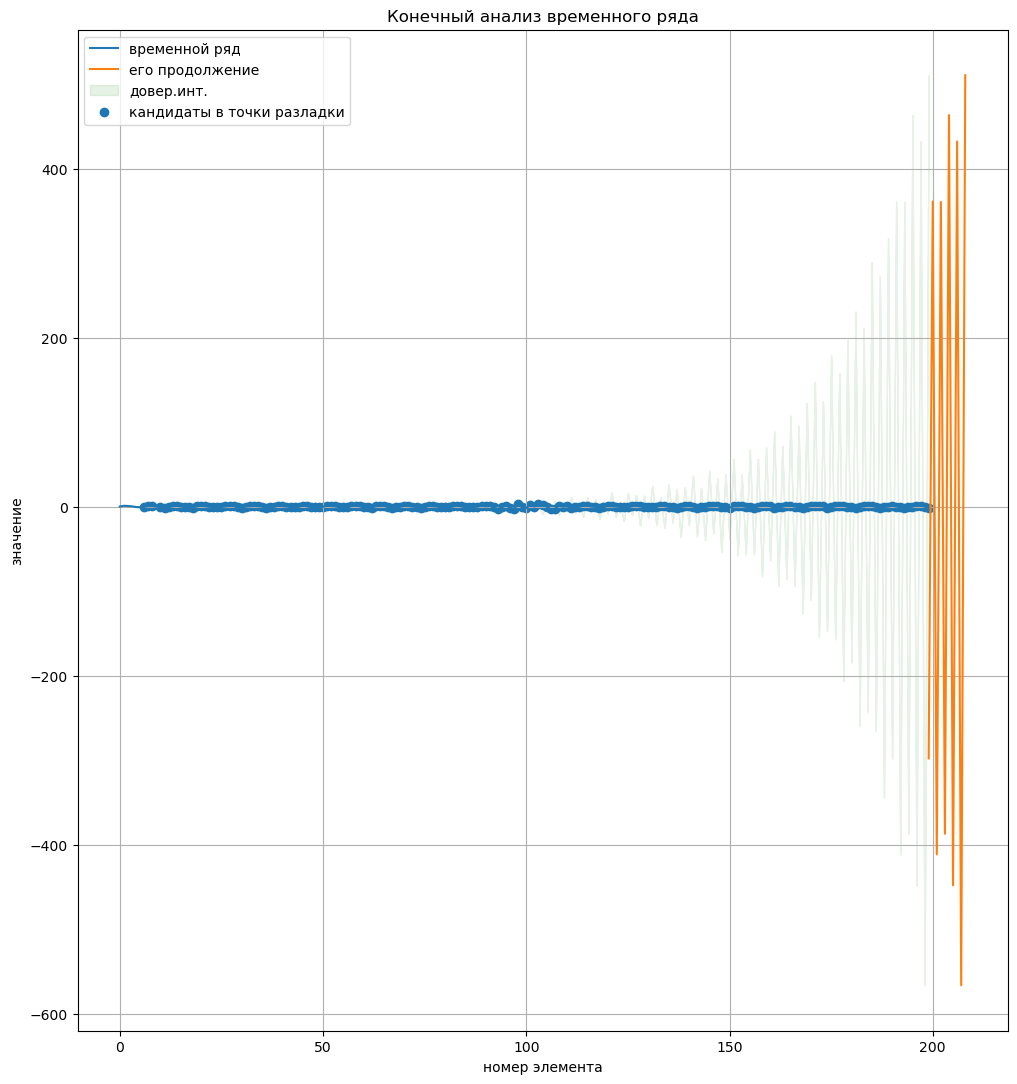

In [73]:
orig, cont, means, dysps = get_params_from_hankel(Hankel_Mat)

plt.figure(figsize = (12, 13))

plt.plot(np.arange(len(vals)), vals, label='временной ряд')
plt.plot(np.arange(len(cont)) + len(vals) - 1, cont, label='его продолжение')
plt.fill_between(np.arange(len(vals)), means - dysps, means + dysps, color='green',alpha=0.1, label='довер.инт.')

cnt, px_t, py_t = search_breakdown_points(vals, dysps, means)
plt.scatter(px_t, py_t, label='кандидаты в точки разладки')

plt.title('Конечный анализ временного ряда')
plt.xlabel('номер элемента')
plt.ylabel('значение')
plt.legend()
plt.grid()

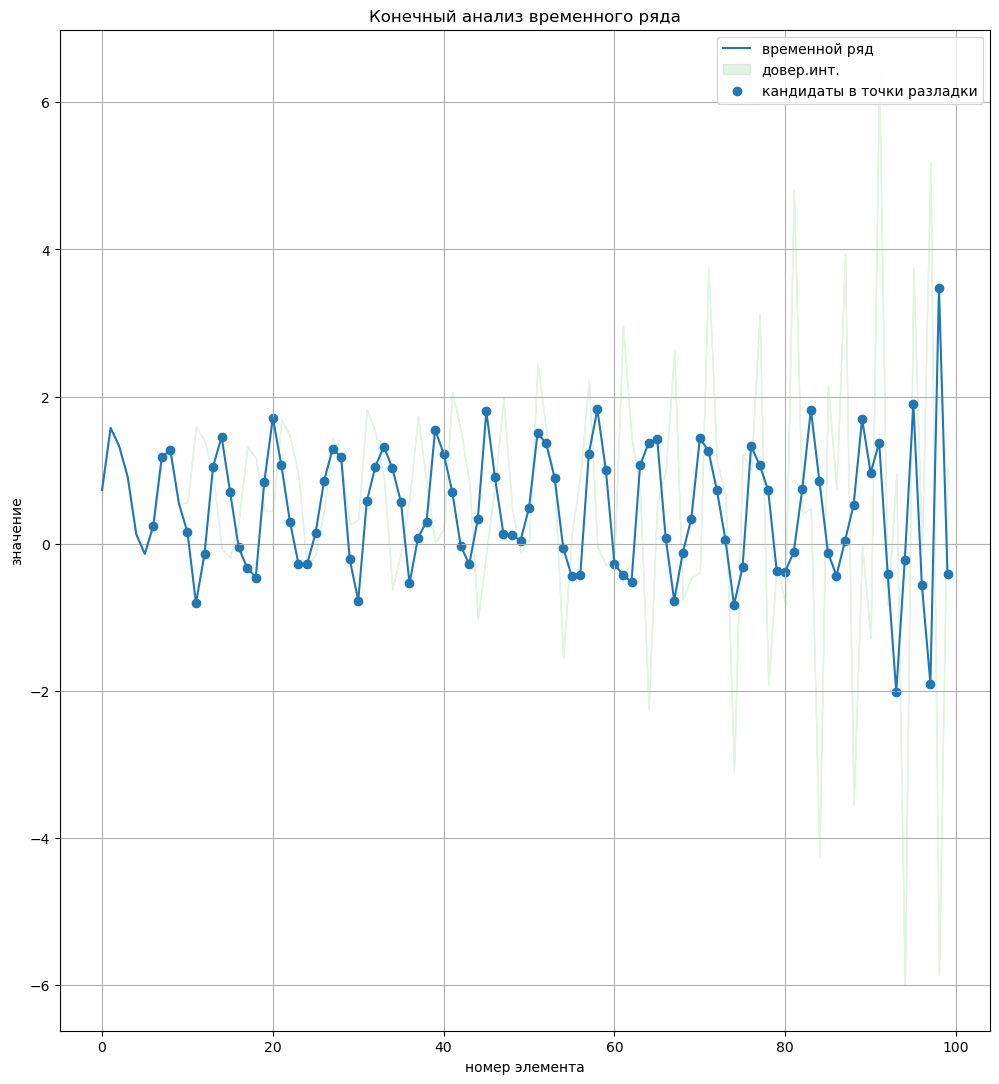

In [74]:
plt.figure(figsize = (12, 13))

c = 100

plt.plot(np.arange(c), vals[:c], label='временной ряд')
#plt.plot(np.arange(len(cont)) + len(vals) - 1, cont, label='его продолжение')
plt.fill_between(np.arange(c), means[:c] - dysps[:c], means[:c] + dysps[:c], color='green',alpha=0.1, label='довер.инт.')

cnt, px_t, py_t = search_breakdown_points(vals[:c], dysps[:c], means[:c])
plt.scatter(px_t, py_t, label='кандидаты в точки разладки')

plt.title('Конечный анализ временного ряда')
plt.xlabel('номер элемента')
plt.ylabel('значение')
plt.legend()
plt.grid()